In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops, find_contours

from skimage.exposure import rescale_intensity

from skimage.morphology import skeletonize

/Users/kuanlin/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
img1 = plt.imread('../Sample Data/3A.tif')

img2 = plt.imread('../Sample Data/3B.tif')

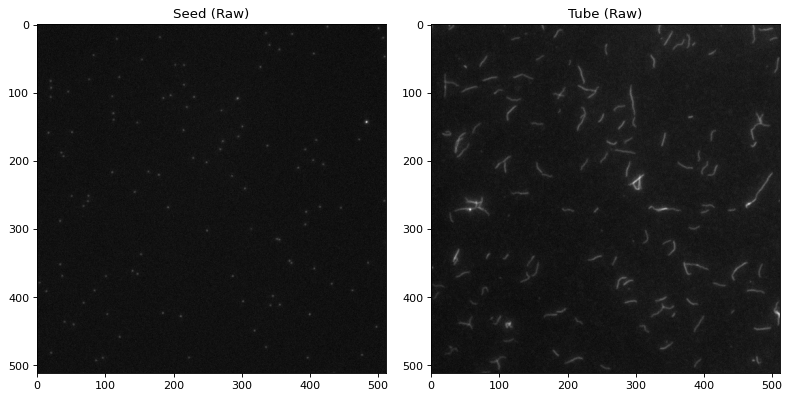

In [3]:
fig = plt.figure(figsize=(10, 5), dpi = 80)

plt.subplot(1, 2, 1)
plt.title("Seed (Raw)")
plt.imshow(img1, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Tube (Raw)")
plt.imshow(img2, cmap="gray")

plt.tight_layout()
plt.show()

## Extract tubes

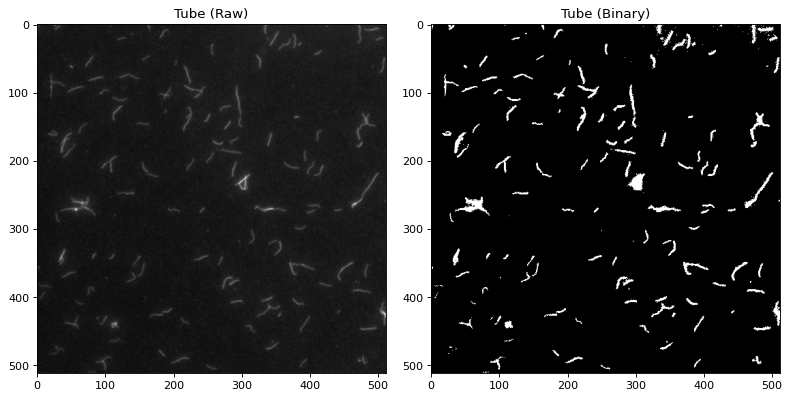

In [4]:
binary = img2 > (img2.mean() + 2*img2.std())

fig = plt.figure(figsize=(10, 5), dpi = 80)

plt.subplot(1, 2, 1)
plt.title("Tube (Raw)")
plt.imshow(img2, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Tube (Binary)")
plt.imshow(binary, cmap="gray")

plt.tight_layout()
plt.show()

In [5]:
# use labeling function to identify connected blobs
label_im = label(binary)
tube_lists = regionprops(label_im)
tube_lists = [i for i in tube_lists if i.area > 10 and i.area < 250]
tube_map = np.zeros_like(binary)

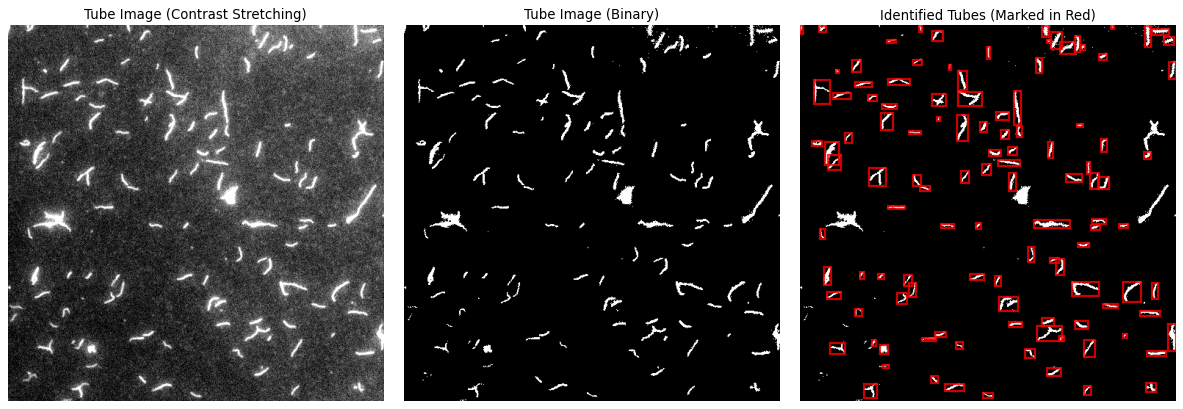

In [9]:
figure = plt.figure(figsize=(15, 5), dpi = 80)

plt.subplot(1, 3, 1)
plt.title("Tube Image (Contrast Stretching)")
p2, p98 = np.percentile(img2, (2, 98))
img_rescale = rescale_intensity(img2, in_range=(p2, p98))
plt.imshow(img_rescale, cmap = "gray")
plt.axis(False)

plt.subplot(1, 3, 2)
plt.title("Tube Image (Binary)")
plt.imshow(binary, cmap = "gray")
plt.axis(False)

ax = plt.subplot(1, 3, 3)
plt.title("Identified Tubes (Marked in Red)")
ax.imshow(binary, cmap="gray")
for i in tube_lists:
    minr, minc, maxr, maxc = i.bbox
    tube_map[minr:maxr, minc:maxc]=1
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2, alpha=.8)
    ax.add_patch(rect)
plt.axis(False)
    
plt.tight_layout()
plt.show()

## Measure Tube

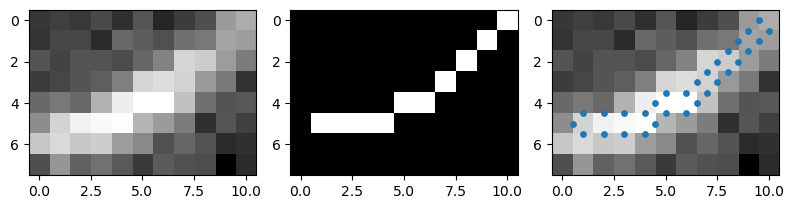

In [58]:
from skimage.morphology import skeletonize
from skimage.measure import find_contours

tube = tube_lists[16]

minr, minc, maxr, maxc = tube.bbox

cropped = img2[minr:maxr, minc:maxc]

fig = plt.figure(figsize=(8, 15), dpi = 100)

plt.subplot(1,3,1)
plt.imshow(cropped, cmap = "gray")

skeleton = skeletonize(tube.image)

plt.subplot(1,3,2)
plt.imshow(skeleton, cmap = "gray")

contours = find_contours(skeleton, .5, fully_connected = 'high')

plt.subplot(1, 3, 3)
plt.imshow(cropped, cmap = "gray")

for contour in contours:
    plt.scatter(contour[:, 1], contour[:, 0], s=15)
    
plt.tight_layout()
plt.show()

In [72]:
def dist(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

def contour_length(data):
    val = 0
    for i in range(len(data)):
        if i != len(data) - 1:
            val += dist(data[i, 0], data[i, 1], data[i+1, 0], data[i+1, 1])
    return (val/2) # 1 pixel = 0.17 um
            
contour_length(contour)

11.82842712474619

## Fix issues with padding

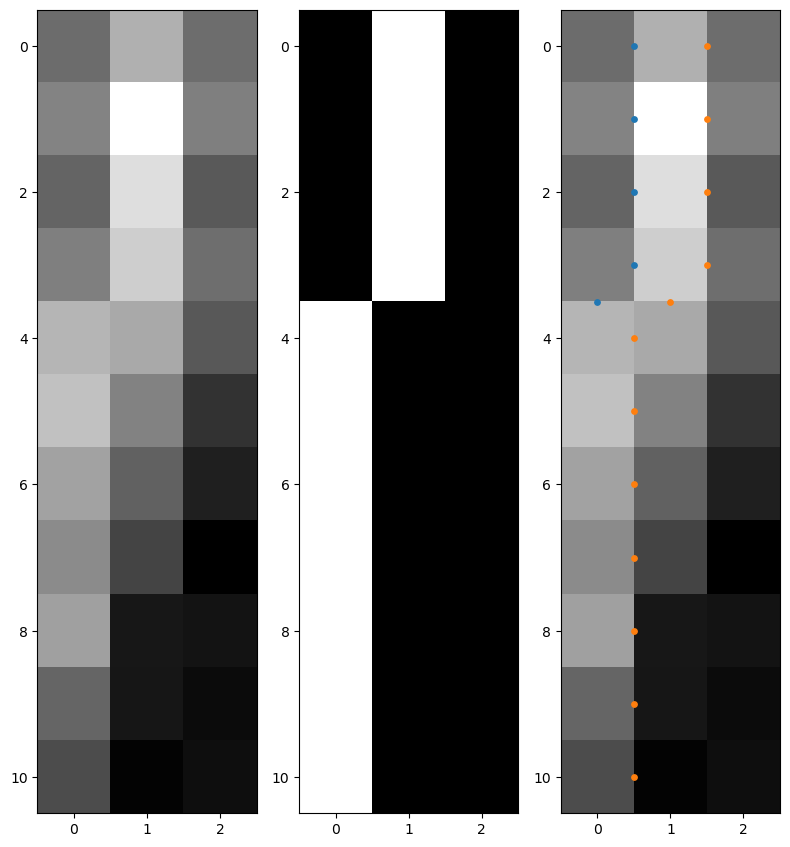

In [63]:
tube = tube_lists[0]

minr, minc, maxr, maxc = tube.bbox

cropped = img2[minr:maxr, minc:maxc]

fig = plt.figure(figsize=(8, 15), dpi = 100)

plt.subplot(1,3,1)
plt.imshow(cropped, cmap = "gray")

skeleton = skeletonize(tube.image)

plt.subplot(1,3,2)
plt.imshow(skeleton, cmap = "gray")

contours = find_contours(skeleton, .5, fully_connected = 'high')

plt.subplot(1, 3, 3)
plt.imshow(cropped, cmap = "gray")

for contour in contours:
    plt.scatter(contour[:, 1], contour[:, 0], s=15)
    
plt.tight_layout()
plt.show()

In [64]:
def pad_image(image):
    padded = np.zeros(shape=(image.shape[0]+2, image.shape[1]+2), dtype = np.uint16)
    padded[1:image.shape[0]+1, 1:image.shape[1]+1] = image
    return padded

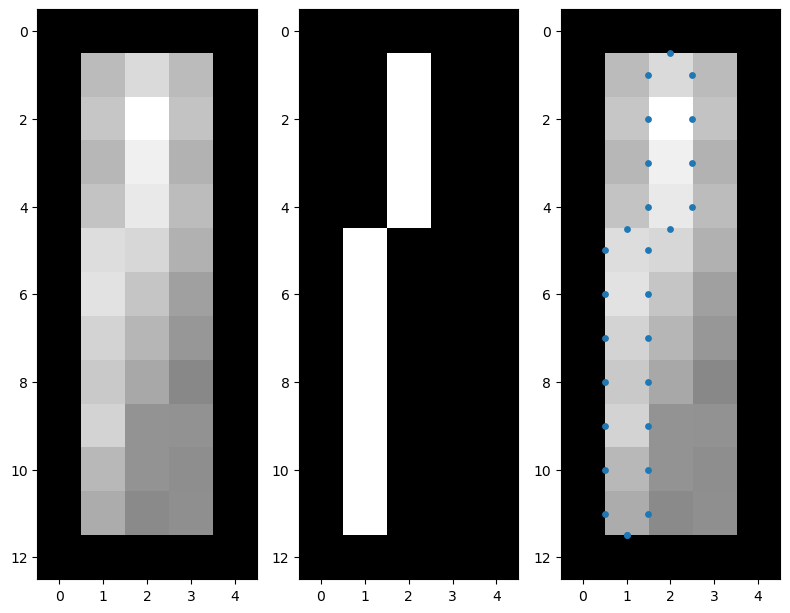

In [69]:
tube = tube_lists[0]

minr, minc, maxr, maxc = tube.bbox

cropped = img2[minr:maxr, minc:maxc]

fig = plt.figure(figsize=(8, 15), dpi = 100)

plt.subplot(1,3,1)
plt.imshow(pad_image(cropped), cmap = "gray")

skeleton = skeletonize(pad_image(tube.image))

plt.subplot(1,3,2)
plt.imshow(skeleton, cmap = "gray")

contours = find_contours(skeleton, .5, fully_connected = 'high')

plt.subplot(1, 3, 3)
plt.imshow(pad_image(cropped), cmap = "gray")

for contour in contours:
    plt.scatter(contour[:, 1], contour[:, 0], s=15)
    
plt.tight_layout()
plt.show()

In [75]:
def tube_length_analysis(tube):
    
    skeleton = skeletonize(pad_image(tube.image))
    
    contours = find_contours(skeleton, .5, fully_connected = 'high')
    
    val = 0
    
    for contour in contours:
        val += contour_length(contour)
        
    return val

tube_length_analysis(tube_lists[16])

12.485281374238564

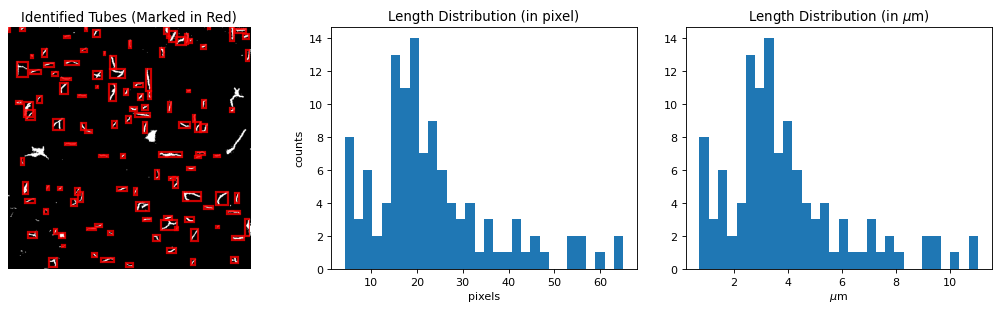

In [102]:
lengths = []

for tube in tube_lists:
    lengths.append(tube_length_analysis(tube))
    
lengths = np.array(lengths)

fig = plt.figure(figsize=(13, 4), dpi = 80)

ax = plt.subplot(1, 3, 1)
plt.title("Identified Tubes (Marked in Red)")
ax.imshow(binary, cmap="gray")
for i in tube_lists:
    minr, minc, maxr, maxc = i.bbox
    tube_map[minr:maxr, minc:maxc]=1
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2, alpha=.8)
    ax.add_patch(rect)
plt.axis(False)

plt.subplot(1, 3, 2)
plt.title("Length Distribution (in pixel)")
plt.hist(lengths, bins = 30)
plt.xlabel("pixels")
plt.ylabel("counts")

plt.subplot(1, 3, 3)
plt.title("Length Distribution (in $\mu$m)")
plt.hist(lengths*0.17, bins = 30)
plt.xlabel("$\mu$m")
# plt.ylabel("counts")

plt.tight_layout()
plt.show()